# Compare the performance of the model trained on augmented data (TimeGAN and SMOTified-GAN) and raw data : PAMAP2

2024.10.24. ~ 2024.11.04.<br>
Gyuyeon Lim (lky473736) 

<br>

- **Reference**
    - https://github.com/uchidalab/time_series_augmentation/blob/master/utils/augmentation.py
    - https://github.com/terryum/Data-Augmentation-For-Wearable-Sensor-Data/blob/master/Example_DataAugmentation_TimeseriesData.ipynb
    - https://pypi.org/project/transform3d/
    - http://dmqm.korea.ac.kr/activity/seminar/390
    - https://hyeongyuu.github.io/machine%20learning/Augmentation_timeseries/
    - https://github.com/andreasKyratzis/PAMAP2-Physical-Activity-Monitoring-Data-Analysis-and-ML/blob/master/pamap2.ipynb
    - https://proceedings.neurips.cc/paper_files/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf
    - https://github.com/flaviagiammarino/time-gan-tensorflow/blob/main/example/example.py
    
<br>

- **addition library**
    - GPUtil
    - memory_profiler
    - transforms3d
    
<br>

### Abstract 

This study evaluates the impact of various data augmentation techniques on the performance of machine learning models trained on the PAMAP2 dataset. In previous work, we focused on basic augmentation methods, including **Jitter**, **Scaling**, **Magnitude Warp**, **Time Warp**, **Random Guided Warp**, **Window Slice**, and **Window Warp**. These techniques allowed us to generate diverse patterns from the original time-series data, helping to address class imbalance and improve model robustness.

To extend this study, we incorporated **T-SMOTE (Time-Series Synthetic Minority Over-sampling Technique)** and **SMOTE (Synthetic Minority Over-sampling Technique)** for advanced data augmentation. T-SMOTE generates synthetic samples that capture complex patterns specific to time-series data, while SMOTE focuses on synthesizing additional samples for minority classes to address imbalance. Our initial comparisons between models trained on data augmented through these advanced methods versus basic techniques provided valuable insights into their impact on model accuracy and generalization.

Building upon these findings, we now introduce **TimeGAN** and **SMOTified-GAN** as generative approaches for time-series augmentation. **TimeGAN**, a generative adversarial network designed specifically for time-series data, synthesizes realistic time-series sequences by learning both the temporal dynamics and feature correlations inherent to the data. This approach is particularly promising for capturing complex, nonlinear dependencies in sequential data, which could lead to more nuanced augmentations that enhance model robustness and generalization. Similarly, **SMOTified-GAN** combines the principles of SMOTE with generative adversarial networks to create synthetic samples, with a focus on addressing class imbalance while maintaining the temporal and statistical properties of the original data. This hybrid approach is expected to offer improvements over traditional SMOTE by generating more realistic and contextually relevant minority class samples.

- **Data**
    - PAMAP2 dataset : https://archive.ics.uci.edu/dataset/231/pamap2+physical+activity+monitoring
    - data abstract : The PAMAP2 Physical Activity Monitoring dataset contains data of 18 different physical activities (such as walking, cycling, playing soccer, etc.), performed by 9 subjects wearing 3 inertial measurement units and a heart rate monitor. The dataset can be used for activity recognition and intensity estimation, while developing and applying algorithms of data processing, segmentation, feature extraction and classification.

    - window size : 100 (will use way of sliding window)

- **Model**
    - CNN-LSTM
    - U-net
    - transformer-encoder

- **Way of Augmentation**
    - **TimeGAN**
    - **SMOTified-GAN**

### Environment and importing libraries


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import psutil
import platform
import GPUtil

# System and CPU information
system = platform.system()
processor = platform.processor()

cpu_count = psutil.cpu_count(logical=True)
cpu_usage = psutil.cpu_percent(interval=1)
virtual_memory = psutil.virtual_memory()

print(f"System: {system}")
print(f"Processor: {processor}")
print(f"CPU Cores: {cpu_count}")
print(f"CPU Usage: {cpu_usage}%")
print(f"Total RAM: {virtual_memory.total / (1024**3):.2f} GB")
print(f"Available RAM: {virtual_memory.available / (1024**3):.2f} GB")
print(f"RAM Usage: {virtual_memory.percent}%")

# GPU information
gpus = GPUtil.getGPUs()
if gpus:
    for gpu in gpus:
        print(f"\nGPU {gpu.id}: {gpu.name}")
        print(f"  Load: {gpu.load * 100:.1f}%")
        print(f"  Free Memory: {gpu.memoryFree / 1024:.2f} GB")
        print(f"  Used Memory: {gpu.memoryUsed / 1024:.2f} GB")
        print(f"  Total Memory: {gpu.memoryTotal / 1024:.2f} GB")
        print(f"  Temperature: {gpu.temperature} °C")
else:
    print("\nNo GPU found.")


System: Linux
Processor: x86_64
CPU Cores: 16
CPU Usage: 12.7%
Total RAM: 1039.13 GB
Available RAM: 1003.87 GB
RAM Usage: 3.4%

GPU 0: CUDA GPU
  Load: nan%
  Free Memory: 39.95 GB
  Used Memory: 0.05 GB
  Total Memory: 40.00 GB
  Temperature: 29.0 °C

GPU 1: CUDA GPU
  Load: nan%
  Free Memory: 39.95 GB
  Used Memory: 0.05 GB
  Total Memory: 40.00 GB
  Temperature: 27.0 °C


In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy
from tqdm import tqdm
from scipy.interpolate import CubicSpline
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


In [5]:
# ignoring future warnings
import warnings
warnings.simplefilter('ignore')

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [7]:
import tensorflow as tf 
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices() )


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18077052324532974817
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40577794048
locality {
  bus_id: 2
  numa_node: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 217361889108296880
physical_device_desc: "device: 0, name: CUDA GPU, pci bus id: 0000:c8:00.0, compute capability: 8.0"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 40577794048
locality {
  bus_id: 2
  numa_node: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 636171575535134982
physical_device_desc: "device: 1, name: CUDA GPU, pci bus id: 0000:cd:00.0, compute capability: 8.0"
xla_global_id: 2144165316
]


In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

-----

### data load, preprocessing


In [9]:
# column names of the data

columns = ['time_stamp', 'activity_id', 'heart_rate', 'hand_temperature', 'hand_3D_acceleration_16_x',  'hand_3D_acceleration_16_y',
         'hand_3D_acceleration_16_z', 'hand_3D_acceleration_6_x', 'hand_3D_acceleration_6_y', 'hand_3D_acceleration_6_z', 'hand_3D_gyroscope_x',
         'hand_3D_gyroscope_y',  'hand_3D_gyroscope_z', 'hand_3D_magnetometer_x', 'hand_3D_magnetometer_y', 'hand_3D_magnetometer_z',
         'hand_4D_orientation_x', 'hand_4D_orientation_y', 'hand_4D_orientation_z', 'hand_4D_orientation_w', 'chest_temperature', 'chest_3D_acceleration_16_x',
         'chest_3D_acceleration_16_y', 'chest_3D_acceleration_16_z', 'chest_3D_acceleration_6_x', 'chest_3D_acceleration_6_y',  'chest_3D_acceleration_6_z',
         'chest_3D_gyroscope_x', 'chest_3D_gyroscope_y', 'chest_3D_gyroscope_z', 'chest_3D_magnetometer_x', 'chest_3D_magnetometer_y',
         'chest_3D_magnetometer_z', 'chest_4D_orientation_x', 'chest_4D_orientation_y', 'chest_4D_orientation_z', 'chest_4D_orientation_w',
         'ankle_temperature', 'ankle_3D_acceleration_16_x', 'ankle_3D_acceleration_16_y', 'ankle_3D_acceleration_16_z', 'ankle_3D_acceleration_6_x',
         'ankle_3D_acceleration_6_y', 'ankle_3D_acceleration_6_z', 'ankle_3D_gyroscope_x', 'ankle_3D_gyroscope_y', 'ankle_3D_gyroscope_z',
         'ankle_3D_magnetometer_x', 'ankle_3D_magnetometer_y', 'ankle_3D_magnetometer_z', 'ankle_4D_orientation_x', 'ankle_4D_orientation_y',
         'ankle_4D_orientation_z', 'ankle_4D_orientation_w']

In [10]:
# data load

def load_data() :
    root = os.path.join('..', '..', '..', 'data', 'PAMAP', 'PAMAP')
    data_list = []  
    
    for i in range(101, 110) : 
        path = os.path.join(root, f"{i}.dat")
        df = pd.read_table(path, header=None, sep='\s+')
        
        print (f"{i}.dat is {df.shape}")
        
        df.columns = columns
        df['id'] = i
        
        print (f"{len(df['activity_id'].unique())}")
        
#         if (len(df['activity_id'].unique()) != 13) :
#             print ("no 13 activity in here. this won't be in completion df")
#             pass
               
#         else : 
        data_list.append(df)  

    #  data = pd.concat(data_list, ignore_index=True)
    # data.reset_index(drop=True, inplace=True)
    
    return data_list

df_list = load_data()

101.dat is (376417, 54)
13
102.dat is (447000, 54)
13
103.dat is (252833, 54)
9
104.dat is (329576, 54)
12
105.dat is (374783, 54)
13
106.dat is (361817, 54)
13
107.dat is (313599, 54)
12
108.dat is (408031, 54)
13
109.dat is (8477, 54)
2


In [11]:
# concatenation the dataframe

df = pd.concat(df_list, ignore_index=True)
df.reset_index(drop=True, inplace=True)

df

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.95990,-58.143800,1.000000,0.000000,0.000000,0.000000,101
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.89190,-58.525300,1.000000,0.000000,0.000000,0.000000,101
2,8.40,0,NaN,30.0000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.41380,-58.399900,1.000000,0.000000,0.000000,0.000000,101
3,8.41,0,NaN,30.0000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.76350,-58.395600,1.000000,0.000000,0.000000,0.000000,101
4,8.42,0,NaN,30.0000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.38790,-58.269400,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872528,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,...,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,0.598531,0.033615,0.799791,-0.031075,109
2872529,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,-4.96890,10.29620,4.43102,...,-0.027006,-0.089808,-45.7474,3.54453,0.108583,0.598428,0.033012,0.799933,-0.030018,109
2872530,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,-5.04613,10.35690,4.14405,...,-0.038024,-0.064709,-46.3997,4.22078,0.105504,0.598233,0.033172,0.800095,-0.029416,109
2872531,100.22,0,NaN,25.1875,-4.64941,9.11129,3.51904,-5.06854,9.75268,3.87359,...,-0.025796,-0.064357,-46.5282,4.48593,0.530240,0.598116,0.033427,0.800180,-0.029208,109


In [12]:
# A function that checks the percentage of missing values,unique values,percentage of one catagory values and type against each column.

'''
    Unique_values : the component that not null
    Missing values : null
    Peercentage of Missing values : number of null / number of all samples
    Data Type : dtype of each cols
'''

def statistics(df):
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum(), df[col].isnull().sum() * 100 / df.shape[0], df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Missing values', 'Percentage of Missing Values', 'Data Type'])
    stats_df.set_index('Feature', drop=True, inplace=True)
    stats_df.drop(stats_df[stats_df['Missing values'] == 0].index, axis=0, inplace=True)
    stats_df.sort_values('Percentage of Missing Values', ascending=False, inplace=True)
    return stats_df

statistics(df).T

Feature,heart_rate,hand_3D_gyroscope_z,hand_temperature,hand_4D_orientation_z,hand_4D_orientation_y,hand_4D_orientation_x,hand_3D_magnetometer_z,hand_3D_magnetometer_y,hand_3D_magnetometer_x,hand_4D_orientation_w,...,chest_3D_acceleration_6_y,chest_3D_gyroscope_x,chest_4D_orientation_z,chest_3D_gyroscope_z,chest_3D_magnetometer_x,chest_3D_magnetometer_y,chest_3D_magnetometer_z,chest_4D_orientation_x,chest_4D_orientation_y,chest_3D_gyroscope_y
Unique_values,146,1875844,138,1247500,1347718,1002405,1130762,1220419,1156337,1400053,...,763044,1827061,1449428,1802080,1410128,626338,1270492,849688,951475,1918959
Missing values,2610265,13141,13141,13141,13141,13141,13141,13141,13141,13141,...,3563,3563,3563,3563,3563,3563,3563,3563,3563,3563
Percentage of Missing Values,90.8698,0.457471,0.457471,0.457471,0.457471,0.457471,0.457471,0.457471,0.457471,0.457471,...,0.124037,0.124037,0.124037,0.124037,0.124037,0.124037,0.124037,0.124037,0.124037,0.124037
Data Type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [13]:
# Function that fills the null values with either the mean or median based on a normal test

def fillnull(columns, df=df):
    from scipy.stats import normaltest
    # Iterating Numerical columns
    for i in columns:
        # Finding Normality of feature
        st, p = normaltest(df[i].dropna())

        # Checking if normal or not
        if p > 0.05:
            # Filling with mean if normal
            df[i].fillna(df[i].mean(), inplace=True)
        else:
            # Filling with median if not normal
            df[i].fillna(df[i].median(), inplace=True)
            
# Taking out column names that have null values
num_cols = statistics(df).index

# Applying function
fillnull(num_cols)

In [14]:
# Acitvity_id = 0 is not an valid activity so it should be dropped
df.drop(df[df['activity_id']==0].index, inplace=True, axis=0)

In [15]:
# As it can be seen here there is no null values any longer in the dataframe.
print (df.isnull().sum())
print (~any(df.isnull()))

time_stamp                    0
activity_id                   0
heart_rate                    0
hand_temperature              0
hand_3D_acceleration_16_x     0
hand_3D_acceleration_16_y     0
hand_3D_acceleration_16_z     0
hand_3D_acceleration_6_x      0
hand_3D_acceleration_6_y      0
hand_3D_acceleration_6_z      0
hand_3D_gyroscope_x           0
hand_3D_gyroscope_y           0
hand_3D_gyroscope_z           0
hand_3D_magnetometer_x        0
hand_3D_magnetometer_y        0
hand_3D_magnetometer_z        0
hand_4D_orientation_x         0
hand_4D_orientation_y         0
hand_4D_orientation_z         0
hand_4D_orientation_w         0
chest_temperature             0
chest_3D_acceleration_16_x    0
chest_3D_acceleration_16_y    0
chest_3D_acceleration_16_z    0
chest_3D_acceleration_6_x     0
chest_3D_acceleration_6_y     0
chest_3D_acceleration_6_z     0
chest_3D_gyroscope_x          0
chest_3D_gyroscope_y          0
chest_3D_gyroscope_z          0
chest_3D_magnetometer_x       0
chest_3D

In [16]:
# information of dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1942872 entries, 2928 to 2872019
Data columns (total 55 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   time_stamp                  float64
 1   activity_id                 int64  
 2   heart_rate                  float64
 3   hand_temperature            float64
 4   hand_3D_acceleration_16_x   float64
 5   hand_3D_acceleration_16_y   float64
 6   hand_3D_acceleration_16_z   float64
 7   hand_3D_acceleration_6_x    float64
 8   hand_3D_acceleration_6_y    float64
 9   hand_3D_acceleration_6_z    float64
 10  hand_3D_gyroscope_x         float64
 11  hand_3D_gyroscope_y         float64
 12  hand_3D_gyroscope_z         float64
 13  hand_3D_magnetometer_x      float64
 14  hand_3D_magnetometer_y      float64
 15  hand_3D_magnetometer_z      float64
 16  hand_4D_orientation_x       float64
 17  hand_4D_orientation_y       float64
 18  hand_4D_orientation_z       float64
 19  hand_4D_orientatio

In [17]:
# delete cols that doesn't need

df = df.drop (['time_stamp', 'id'], axis=1)
df.columns

Index(['activity_id', 'heart_rate', 'hand_temperature',
       'hand_3D_acceleration_16_x', 'hand_3D_acceleration_16_y',
       'hand_3D_acceleration_16_z', 'hand_3D_acceleration_6_x',
       'hand_3D_acceleration_6_y', 'hand_3D_acceleration_6_z',
       'hand_3D_gyroscope_x', 'hand_3D_gyroscope_y', 'hand_3D_gyroscope_z',
       'hand_3D_magnetometer_x', 'hand_3D_magnetometer_y',
       'hand_3D_magnetometer_z', 'hand_4D_orientation_x',
       'hand_4D_orientation_y', 'hand_4D_orientation_z',
       'hand_4D_orientation_w', 'chest_temperature',
       'chest_3D_acceleration_16_x', 'chest_3D_acceleration_16_y',
       'chest_3D_acceleration_16_z', 'chest_3D_acceleration_6_x',
       'chest_3D_acceleration_6_y', 'chest_3D_acceleration_6_z',
       'chest_3D_gyroscope_x', 'chest_3D_gyroscope_y', 'chest_3D_gyroscope_z',
       'chest_3D_magnetometer_x', 'chest_3D_magnetometer_y',
       'chest_3D_magnetometer_z', 'chest_4D_orientation_x',
       'chest_4D_orientation_y', 'chest_4D_orientat

In [18]:
import pandas as pd

def correlation_matrix(df):
    corr = df.corr()

    sorted_corr = corr['activity_id'].abs().sort_values(ascending=False)

    return sorted_corr

sorted_correlations = correlation_matrix(df)

print(sorted_correlations)

activity_id                   1.000000
chest_3D_acceleration_6_z     0.429279
chest_3D_acceleration_16_z    0.428210
ankle_4D_orientation_w        0.337902
chest_4D_orientation_x        0.324685
chest_3D_magnetometer_y       0.298333
chest_3D_magnetometer_z       0.265201
chest_3D_magnetometer_x       0.241262
ankle_3D_magnetometer_z       0.209349
hand_4D_orientation_x         0.207247
ankle_3D_magnetometer_x       0.199028
ankle_temperature             0.196692
hand_3D_magnetometer_y        0.188350
ankle_4D_orientation_y        0.187077
chest_temperature             0.160191
hand_temperature              0.159274
chest_3D_acceleration_16_x    0.149992
chest_3D_acceleration_6_x     0.147551
ankle_3D_acceleration_6_x     0.145586
ankle_3D_acceleration_16_x    0.134114
hand_3D_acceleration_16_x     0.131847
hand_3D_acceleration_6_x      0.131142
hand_3D_acceleration_6_z      0.118543
hand_3D_acceleration_16_z     0.116912
chest_3D_acceleration_16_y    0.105699
hand_4D_orientation_z    

In [19]:
'''
    To reduce the complexity of the model due to too many features, 
    only features related to 'ankle', 'chest', 'heart rate' will be retained.
    because of memory fraction
'''

col_activity_id = df['activity_id']
col_heart_rate = df['heart_rate']

df = df.filter(regex='(ankle|chest)', axis=1) # using regex (ankle or chest)

df['heart_rate'] = col_heart_rate
df['activity_id'] = col_activity_id

In [20]:
# see that target is 0-based

print (df['activity_id'].unique())


'''
    we need to encoding now to 0-based
    (labelencoding)
'''

[ 1  2  3 17 16 12 13  4  7  6  5 24]


'\n    we need to encoding now to 0-based\n    (labelencoding)\n'

In [21]:
# label encoding

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['activity_id'] = encoder.fit_transform(df['activity_id'])

print (df['activity_id'].unique())

[ 0  1  2 10  9  7  8  3  6  5  4 11]


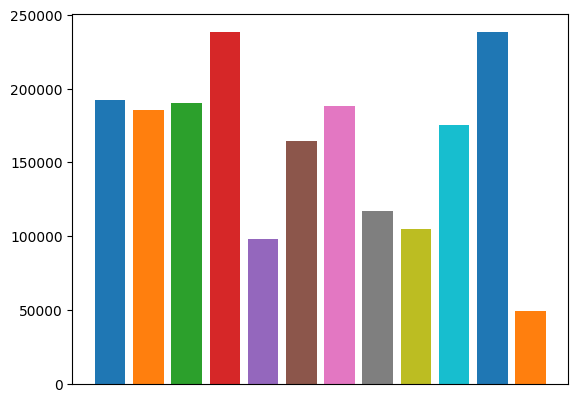

3     238761
10    238690
0     192523
2     189931
6     188107
1     185188
9     175353
5     164600
7     117216
8     104944
4      98199
11     49360
Name: activity_id, dtype: int64


"\n    This situation solved using SMOTE and oversampling random position at records before bunches of documents.\n    But this data is time-series, has depandancy of time.\n    \n    so i will do the original augmentation that Terry Taewoong Um offered. \n    That file will be uploaded at './augmentation'\n"

In [22]:
# activity_id - countplot, value_count

import math

target = np.unique(df['activity_id'])

width = 1
for compo in target : 
    plt.bar(width, len(df[df['activity_id'] == compo]), 
            label=compo)
    width += 1
    
plt.xticks([], [])
plt.show()

print (df['activity_id'].value_counts())

'''
    This situation solved using SMOTE and oversampling random position at records before bunches of documents.
    But this data is time-series, has depandancy of time.
    
    so i will do the original augmentation that Terry Taewoong Um offered. 
    That file will be uploaded at './augmentation'
'''

In [23]:
# Z-score normalization

from sklearn.preprocessing import StandardScaler

X = df[[feature_name for feature_name in df.columns if feature_name != 'activity_id']]
y = df['activity_id']

SS = StandardScaler()
X = SS.fit_transform(X)

df = pd.DataFrame(data=X, 
                        columns = [feature_name for feature_name in df.columns if feature_name != 'activity_id'])
df['activity_id'] = y.values

df

,chest_temperature,chest_3D_acceleration_16_x,chest_3D_acceleration_16_y,chest_3D_acceleration_16_z,chest_3D_acceleration_6_x,chest_3D_acceleration_6_y,chest_3D_acceleration_6_z,chest_3D_gyroscope_x,chest_3D_gyroscope_y,chest_3D_gyroscope_z,...,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,heart_rate,activity_id
0,-2.671552,-0.119921,0.306155,-0.042085,-0.031848,0.321978,-0.073665,0.069143,0.008567,-0.094160,...,-0.002954,-1.612155,-1.768779,-3.842566,2.042947,0.015937,-0.910038,0.118979,0.005952,0
1,-2.671552,-0.076152,0.306108,-0.041795,-0.040394,0.328214,-0.073627,0.030607,-0.063867,-0.116397,...,-0.000834,-1.600335,-1.743646,-3.842363,2.042947,0.015937,-0.910038,0.118979,0.005952,0
2,-2.671552,-0.036209,0.321155,-0.090380,-0.031419,0.334419,-0.060953,-0.015592,0.047400,-0.074207,...,-0.006259,-1.570259,-1.718901,-3.854879,2.042947,0.015937,-0.910038,0.118979,0.005952,0
3,-2.671552,-0.055467,0.321393,-0.057974,-0.014315,0.331303,-0.070507,0.026012,-0.106841,-0.164027,...,0.009598,-1.593402,-1.779832,-3.817681,2.042947,0.015937,-0.910038,0.118979,0.005952,0
4,-2.671552,0.010843,0.321372,-0.049403,-0.014795,0.318868,-0.086386,-0.011805,-0.044453,-0.051662,...,-0.006979,-1.562796,-1.780742,-3.817925,2.042947,0.015937,-0.910038,0.118979,-0.975223,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942867,-2.546063,-0.412642,0.259591,-0.141467,-0.441591,0.275760,-0.196486,-0.340703,-0.264536,0.282075,...,-0.000899,-0.775617,-0.103795,-0.885062,0.468808,-0.495552,1.215173,-0.671289,0.005952,11
1942868,-2.546063,-0.348588,0.220875,-0.157180,-0.459996,0.225957,-0.209268,-0.204353,-0.282429,0.223975,...,-0.005936,-0.789134,-0.103127,-0.849070,0.468646,-0.495696,1.215502,-0.670876,0.005952,11
1942869,-2.546063,-0.326475,0.251680,-0.157136,-0.381987,0.216529,-0.193624,-0.062557,-0.224092,0.335552,...,-0.004977,-0.760794,-0.122171,-0.848952,0.467805,-0.496194,1.216303,-0.670112,0.005952,11
1942870,-2.546063,-0.263392,0.259102,-0.189275,-0.346874,0.232057,-0.180979,-0.051073,-0.227636,0.384813,...,-0.007352,-0.782375,-0.091495,-0.841855,0.467511,-0.496153,1.217100,-0.669379,6.628887,11


In [24]:
# input, target split

input_PAMAP = df.drop('activity_id', axis=1)
target_PAMAP = df['activity_id']

input_PAMAP.shape, target_PAMAP.shape

((1942872, 35), (1942872,))

------

### sliding window : split_sequences_freq()

<img src="https://velog.velcdn.com/images/wlwl99/post/e0ebddc2-e075-41e5-bec6-ac424364d1da/image.png" width=400px>

The function above is designed using the **sliding window technique**, but this time the target is determined by **frequency** rather than the last value. Sliding window is a common approach used in two-pointer algorithms, where elements are selected by sliding across the dataset, as illustrated in the earlier figure.

In this function, **`len(sequences)` represents the number of records (rows) in the DataFrame**. The loop iterates through each row, with `i` representing the current row index. `end_ix` is calculated by adding `n_steps` to the current row index, where `n_steps` is the size of the window. Here, the **window slides over the data, selecting a block of rows**.

The loop terminates if `end_ix` exceeds the total number of rows in the DataFrame. Inside the loop, `seq_x` is the input data that selects the rows between the `i`-th and `end_ix - 1`-th row, excluding the last column (target column). `seq_y` is the corresponding target data, which includes the values in the last column for those rows.

Instead of using the last target value as in the previous approach, **the most frequent target class within the window** is selected as the target. This is done using the `Counter` from the `collections` module, which finds the most common class in `seq_y`. Finally, the input data (`X`) and the most frequent class (`y`) are stored for each window.

In [25]:
# sliding window (judging by frequency)

from collections import Counter

def split_sequences_freq(sequences, n_steps, hop=1):
    X, y = list(), list()
    
    # Check if sequences is a DataFrame, convert if necessary
    if not isinstance(sequences, pd.DataFrame):
        sequences = pd.DataFrame(sequences)

    i = 0
    while (i < len(sequences)) : 
        end_ix = i + n_steps

        if end_ix > len(sequences):
            break

        seq_x = sequences.iloc[i:end_ix, :-1].values
        seq_y = sequences.iloc[i:end_ix, -1].values   
        
        # Find the most frequent class in seq_y
        most_frequent_class = Counter(seq_y).most_common(1)[0][0]
        
        X.append(seq_x)
        y.append(int(most_frequent_class))
        
        i += hop

    return np.array(X), np.array(y)

------

### Modeling

In [26]:
# CNN-LSTM

from tensorflow import keras
from tensorflow.keras import layers, regularizers

def build_CNN_LSTM(input_shape, target_size, l2_lambda=0.01):
    model = keras.Sequential()

    # Convolutional layers
    model.add(layers.Conv1D(128, kernel_size=4, padding='same', strides=1, activation='relu', 
                            kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(64, kernel_size=3, padding='same', strides=1, activation='relu', 
                            kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dropout(0.4))

    # LSTM layers
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=False))
    model.add(layers.Dropout(0.5))

    # Fully connected layers
    model.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(60, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))

    # Output layer
    model.add(layers.Dense(target_size, activation='softmax'))

    return model


In [27]:
from tensorflow.keras import layers, models, regularizers

def build_unet_1d_custom(input_shape, num_classes, l2_lambda=0.01):

    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(inputs)
    c1 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(c1)
    p1 = layers.MaxPooling1D(pool_size=2)(c1)  # Downsampling

    c2 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(p1)
    c2 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(c2)
    p2 = layers.MaxPooling1D(pool_size=2)(c2)  # Downsampling

    c3 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(p2)
    c3 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(c3)
    p3 = layers.MaxPooling1D(pool_size=2)(c3)  # Downsampling

    # Bottleneck
    b1 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(p3)
    b1 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(b1)

    # Decoder
    u3 = layers.Conv1DTranspose(16, kernel_size=2, strides=2, padding='same')(b1)  # Upsampling
    c3_shape = layers.Lambda(lambda x: x[:, :u3.shape[1], :])(c3)  # Adjust shape of c3 to match u3
    u3 = layers.concatenate([u3, c3_shape], axis=-1)  # Concatenate

    c4 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(u3)
    c4 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(c4)

    u4 = layers.Conv1DTranspose(32, kernel_size=2, strides=2, padding='same')(c4)  # Upsampling
    c2_shape = layers.Lambda(lambda x: x[:, :u4.shape[1], :])(c2)  # Adjust shape of c2 to match u4
    u4 = layers.concatenate([u4, c2_shape], axis=-1)  # Concatenate

    c5 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(u4)
    c5 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(c5)

    # Output layer
    f1 = layers.Flatten()(c5)
    dense1 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(f1)
    outputs = layers.Dense(num_classes, activation='softmax')(dense1)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model


In [28]:
# transformer-encoder

from tensorflow.keras import regularizers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2, l2_lambda=0.02):
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu",
                           kernel_regularizer=regularizers.l2(l2_lambda))(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1,
                           kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_transformer(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.2,
    mlp_dropout=0.3,
    n_classes=0,
    l2_lambda=0.02
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, l2_lambda)

    x = keras.layers.GlobalMaxPooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="relu",
                              kernel_regularizer=regularizers.l2(l2_lambda))(x)
        x = keras.layers.Dropout(mlp_dropout)(x)
    outputs = keras.layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [29]:
# build pipeline to fit

import time
from memory_profiler import profile
from keras.callbacks import Callback

class EpochTimeLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()  

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time  
        print(f"epoch {epoch + 1} completed : {elapsed_time:.2f} seconds", end='\n')

@profile  # to protect memory overflow
def run_all_model(X, y, models, epochs=50):
    histories = {
        'CNN_LSTM' : None,
        'UNet' : None,
        'transformer_encoder' : None
    }
    
    trained_models = {
        'CNN_LSTM' : None,
        'UNet' : None,
        'transformer_encoder' : None
    }
    
#     early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    for idx, model in enumerate(models) : 
        print (f"model {idx} running")    
        try:
            start_time = time.time()
            history = model.fit(X, y, epochs=epochs, 
                                validation_split=0.2,
                                batch_size=512,
                                callbacks=[EpochTimeLogger()], 
                                verbose=0)
            
            end_time = time.time()
            total_time = end_time - start_time
            avg_time_per_epoch = total_time / epochs
            
            print(f"Total training time: {total_time / 60:.2f} minutes")
            print(f"Average time per epoch: {avg_time_per_epoch:.2f} seconds")
            
            if idx == 0: 
                histories['CNN_LSTM'] = history
                print ("CNN_LSTM completed")
                trained_models['CNN_LSTM'] = model
            elif idx == 1: 
                histories['UNet'] = history
                print ("UNet completed")
                trained_models['UNet'] = model
            else: 
                histories['transformer_encoder'] = history
                print ("transformer_encoder completed")
                trained_models['transformer_encoder'] = model
                
        except Exception as e: 
            print (f"Error occurred while running model {idx}: {e}")
            
        print ()
    
    return histories, trained_models

def activate_all_model(X, y, input_shape, n_classes, epochs=50):
    CNN_LSTM = build_CNN_LSTM(input_shape=input_shape,
                             target_size=n_classes)
    UNet = build_unet_1d_custom(input_shape=input_shape,
                               num_classes=n_classes)
    transformer_encoder = build_transformer(
                                input_shape=input_shape,
                                head_size=64,
                                num_heads=4,
                                ff_dim=4,
                                num_transformer_blocks=3,
                                mlp_units=[32],
                                mlp_dropout=0.1,
                                dropout=0.2,
                                n_classes=n_classes
                            )
    
    CNN_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'], 
                     loss='sparse_categorical_crossentropy')
    UNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'], 
                 loss='sparse_categorical_crossentropy')
    transformer_encoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'], 
                                loss='sparse_categorical_crossentropy')
    
    models = [CNN_LSTM, UNet, transformer_encoder]
    
    CNN_LSTM.build(input_shape=(None, *input_shape))
    UNet.build(input_shape=(None, *input_shape))
    transformer_encoder.build(input_shape=(None, *input_shape))
    
    print(f"CNN_LSTM model parameters: {CNN_LSTM.count_params()}")
    print(f"UNet model parameters: {UNet.count_params()}")
    print(f"Transformer Encoder model parameters: {transformer_encoder.count_params()}")

    histories, trained_models = run_all_model(X, y, models, epochs)
    return histories, trained_models

------

### original dataframe (no augmentation)

In [30]:
# no augmentation. train set, test set split

print (df.shape)

idx = int(df.shape[0]*0.8)

X_train = df.iloc[:idx][[feature_name for feature_name in df.columns if feature_name != 'activity_id']]
y_train = df.iloc[:idx]['activity_id']
X_test = df.iloc[idx:][[feature_name for feature_name in df.columns if feature_name != 'activity_id']]
y_test = df.iloc[idx:]['activity_id']

X_train.shape, X_test.shape

(1942872, 36)


((1554297, 35), (388575, 35))

In [31]:
# no augmentation. so just use split_sequence_freq

'''
    the data information indicates that the sampled data has a frequency of 100Hz
    so the window size should be configured to be the same as the frequency
'''

train_set = np.c_[X_train, y_train]
test_set = np.c_[X_test, y_test]

X_train_seq, y_train_seq = split_sequences_freq(train_set, 100, 20) # tie 100 records, hop 20
print ("train : ", X_train_seq.shape, y_train_seq.shape)

X_test_seq, y_test_seq = split_sequences_freq(test_set, 100, 20) # tie 100 records, hop 20
print ("test : ", X_test_seq.shape, y_test_seq.shape)

print (len(set(y_train_seq)))
print (len(set(y_test_seq)))

train :  (77710, 100, 35) (77710,)
test :  (19424, 100, 35) (19424,)
12
12


In [32]:
# compile -> fit -> return histories

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
n_classes = 12
histories_original, trained_models = activate_all_model(X_train_seq, y_train_seq, input_shape, n_classes)

CNN_LSTM model parameters: 107228
UNet model parameters: 164572
Transformer Encoder model parameters: 114934
ERROR: Could not find file /tmp/ipykernel_409/2458058224.py
model 0 running
epoch 1 completed : 23.37 seconds
epoch 2 completed : 2.22 seconds
epoch 3 completed : 2.14 seconds
epoch 4 completed : 2.16 seconds
epoch 5 completed : 2.11 seconds
epoch 6 completed : 2.11 seconds
epoch 7 completed : 2.12 seconds
epoch 8 completed : 2.12 seconds
epoch 9 completed : 2.10 seconds
epoch 10 completed : 2.14 seconds
epoch 11 completed : 2.15 seconds
epoch 12 completed : 2.14 seconds
epoch 13 completed : 2.16 seconds
epoch 14 completed : 2.17 seconds
epoch 15 completed : 2.14 seconds
epoch 16 completed : 2.12 seconds
epoch 17 completed : 2.10 seconds
epoch 18 completed : 2.09 seconds
epoch 19 completed : 2.11 seconds
epoch 20 completed : 2.08 seconds
epoch 21 completed : 2.09 seconds
epoch 22 completed : 2.09 seconds
epoch 23 completed : 2.10 seconds
epoch 24 completed : 2.12 seconds
epoch 2

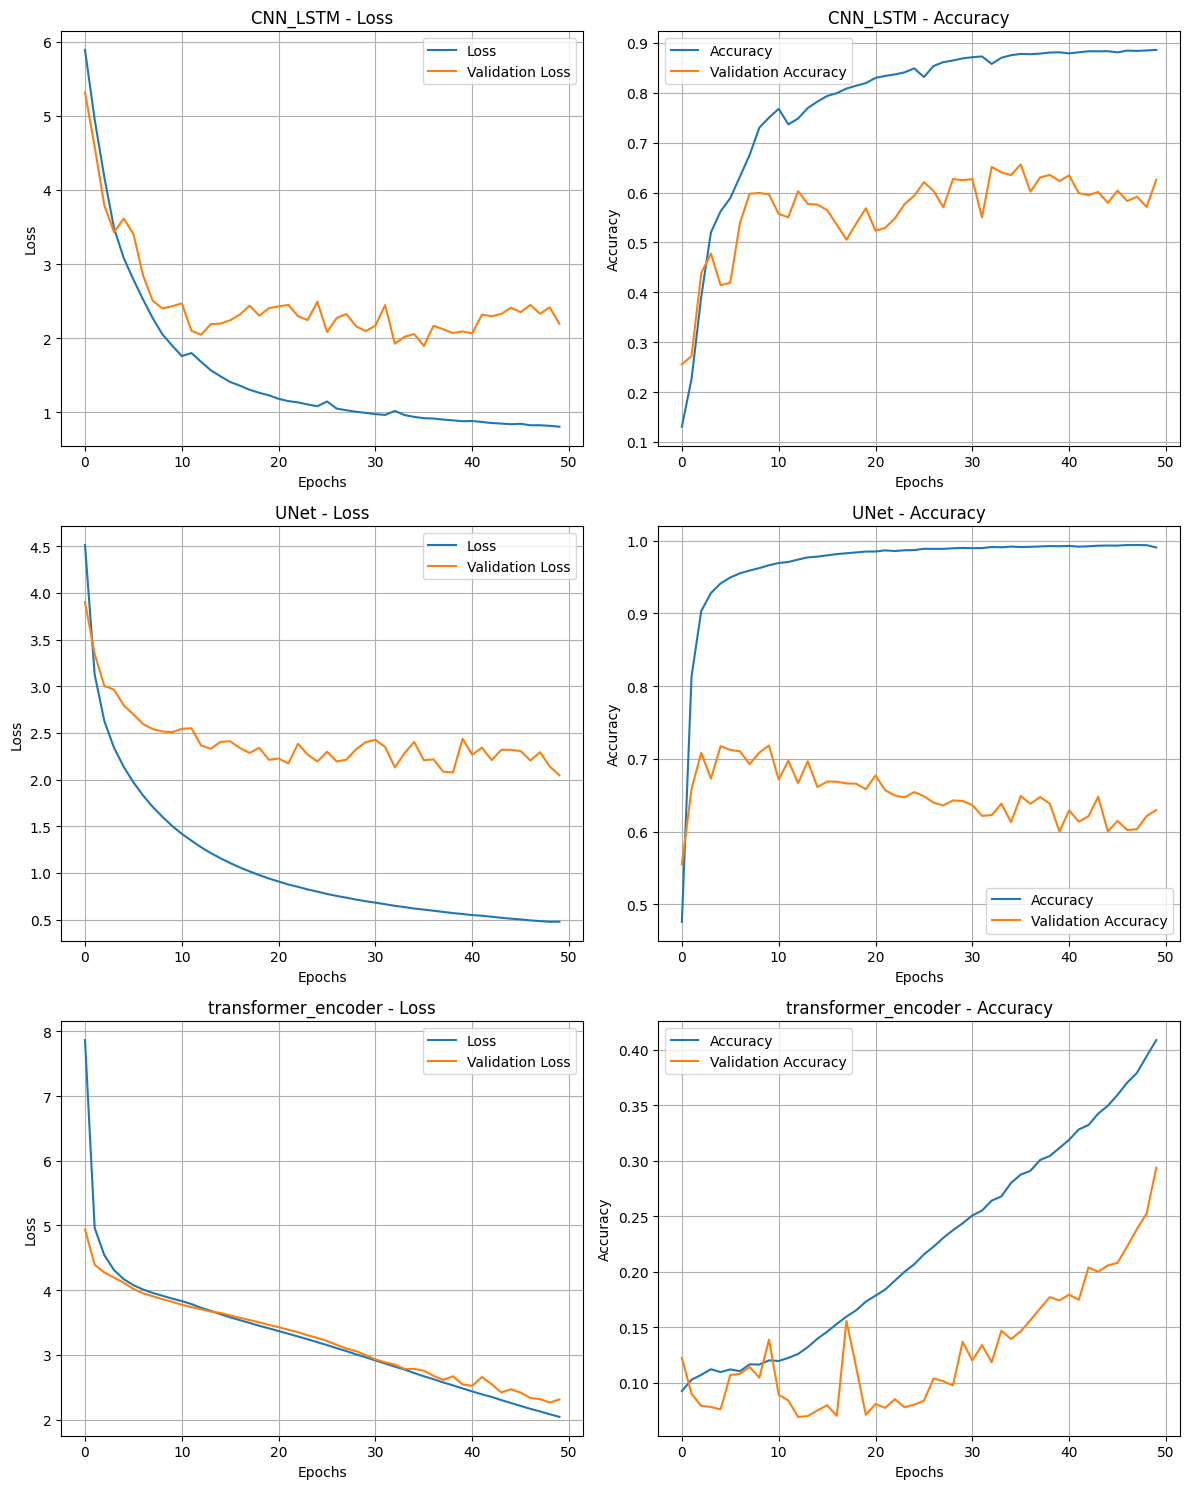

In [33]:
# loss, validation loss, acc, validation acc visualliztion

def draw_history(histories):
    num_models = len(histories)
    fig, ax = plt.subplots(num_models, 2, figsize=(12, 5 * num_models))

    for i, (model_name, history) in enumerate(histories.items()):
        ax[i, 0].plot(history.history['loss'], label='Loss')
        ax[i, 0].plot(history.history['val_loss'], label='Validation Loss')
        ax[i, 0].set_title(f'{model_name} - Loss')
        ax[i, 0].set_xlabel('Epochs')
        ax[i, 0].set_ylabel('Loss')
        ax[i, 0].legend()
        ax[i, 0].grid()

        ax[i, 1].plot(history.history['accuracy'], label='Accuracy')
        ax[i, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax[i, 1].set_title(f'{model_name} - Accuracy')
        ax[i, 1].set_xlabel('Epochs')
        ax[i, 1].set_ylabel('Accuracy')
        ax[i, 1].legend()
        ax[i, 1].grid()

    plt.tight_layout()
    plt.show()

draw_history(histories_original)

In [34]:
# evaulate

def extract_train_test_scores(models, X_train, y_train, X_test, y_test) :
    scores = {}
    for model_name, model in models.items():
        if model:
            train_score = model.evaluate(X_train, y_train, verbose=0)
            test_score  = model.evaluate(X_test, y_test, verbose=0)
            scores[model_name] = {'train_score': train_score, 'test_score': test_score}
    return scores


evaluation_original = extract_train_test_scores(trained_models, X_train_seq, y_train_seq,
                                                X_test_seq, y_test_seq)
print (evaluation_original)

{'CNN_LSTM': {'train_score': [1.0087721347808838, 0.8511903285980225], 'test_score': [3.4123973846435547, 0.46880146861076355]}, 'UNet': {'train_score': [0.780137836933136, 0.9214258193969727], 'test_score': [3.147555351257324, 0.5228583216667175]}, 'transformer_encoder': {'train_score': [2.3526155948638916, 0.29764509201049805], 'test_score': [2.4313278198242188, 0.3379839360713959]}}


In [35]:
# get accuracy, precision, recall, F1 score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def extract_performance_metrics(models, X_test, y_test) :
    metrics = {}
    for model_name, model in models.items():
        if model:
            y_pred = model.predict(X_test)
            y_pred_classes = y_pred.argmax(axis=1)
            accuracy  = accuracy_score(y_test, y_pred_classes)
            precision = precision_score(y_test, y_pred_classes, average='weighted')
            recall    = recall_score(y_test, y_pred_classes, average='weighted')
            f1        = f1_score(y_test, y_pred_classes, average='weighted')
            metrics[model_name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1}
    return metrics

performances_original = extract_performance_metrics(trained_models, X_test_seq, y_test_seq)
print (performances_original)

607/607 [==============================] - 2s 2ms/step
{'CNN_LSTM': {'accuracy': 0.4688014827018122, 'precision': 0.39707594109733196, 'recall': 0.4688014827018122, 'f1_score': 0.4078108370546759}, 'UNet': {'accuracy': 0.5228583196046128, 'precision': 0.525907203571794, 'recall': 0.5228583196046128, 'f1_score': 0.507856182048503}, 'transformer_encoder': {'accuracy': 0.3379839373970346, 'precision': 0.38608098562649973, 'recall': 0.3379839373970346, 'f1_score': 0.2864655871633395}}


607/607 [==============================] - 2s 4ms/step
Classification Report for CNN_LSTM:

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1208
           1       0.06      0.01      0.01      1147
           2       0.14      0.25      0.18      1258
           3       0.51      0.73      0.60      3262
           4       0.53      0.28      0.37      1011
           5       0.96      0.65      0.77      2408
           6       0.00      0.00      0.00      2881
           7       0.53      0.84      0.65      1466
           8       0.32      0.61      0.42      1064
           9       0.34      0.76      0.47      1313
          10       0.00      0.00      0.00      1649
          11       0.31      0.73      0.43       757

    accuracy                           0.47     19424
   macro avg       0.39      0.48      0.40     19424
weighted avg       0.40      0.47      0.41     19424



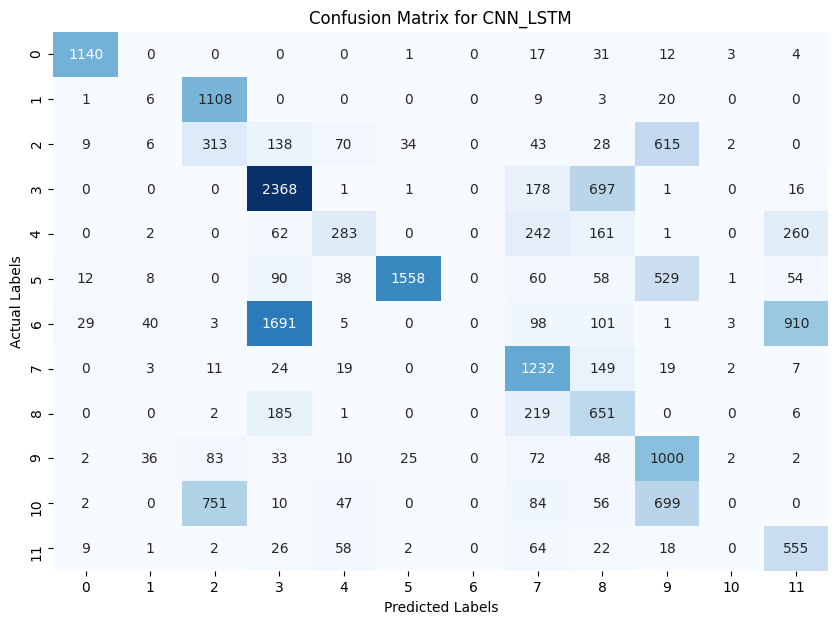

607/607 [==============================] - 1s 2ms/step
Classification Report for UNet:

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1208
           1       0.51      0.96      0.66      1147
           2       0.35      0.40      0.37      1258
           3       0.58      0.53      0.56      3262
           4       0.37      0.66      0.47      1011
           5       0.95      0.77      0.85      2408
           6       0.41      0.23      0.29      2881
           7       0.72      0.52      0.60      1466
           8       0.15      0.39      0.22      1064
           9       0.55      0.64      0.59      1313
          10       0.02      0.00      0.00      1649
          11       0.56      0.63      0.60       757

    accuracy                           0.52     19424
   macro avg       0.50      0.56      0.51     19424
weighted avg       0.53      0.52      0.51     19424



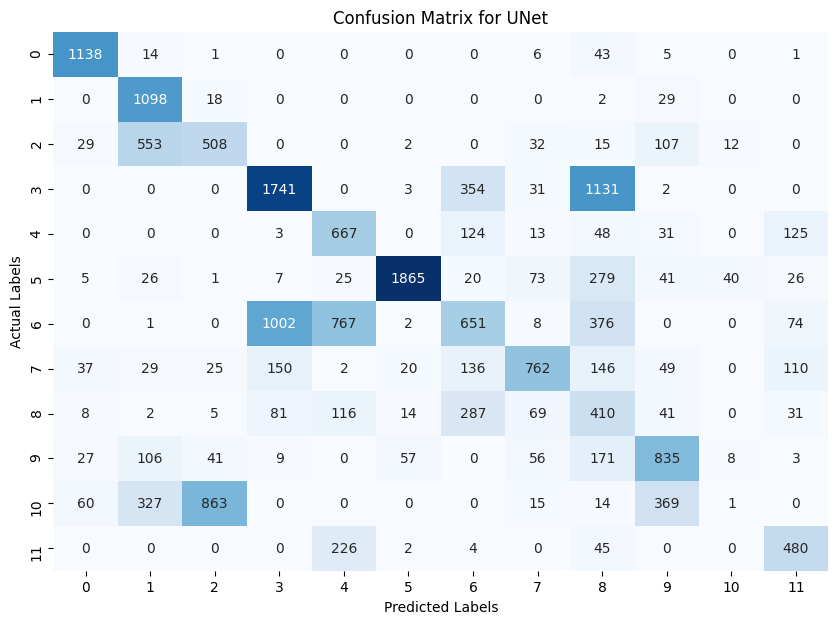

607/607 [==============================] - 1s 2ms/step
Classification Report for transformer_encoder:

              precision    recall  f1-score   support

           0       0.04      0.01      0.01      1208
           1       0.00      0.00      0.00      1147
           2       0.11      0.38      0.17      1258
           3       0.44      0.89      0.59      3262
           4       0.79      0.83      0.81      1011
           5       0.66      0.31      0.42      2408
           6       0.22      0.00      0.00      2881
           7       0.77      0.04      0.08      1466
           8       0.22      0.15      0.18      1064
           9       0.27      0.11      0.16      1313
          10       0.29      0.54      0.38      1649
          11       0.89      0.41      0.56       757

    accuracy                           0.34     19424
   macro avg       0.39      0.31      0.28     19424
weighted avg       0.39      0.34      0.29     19424



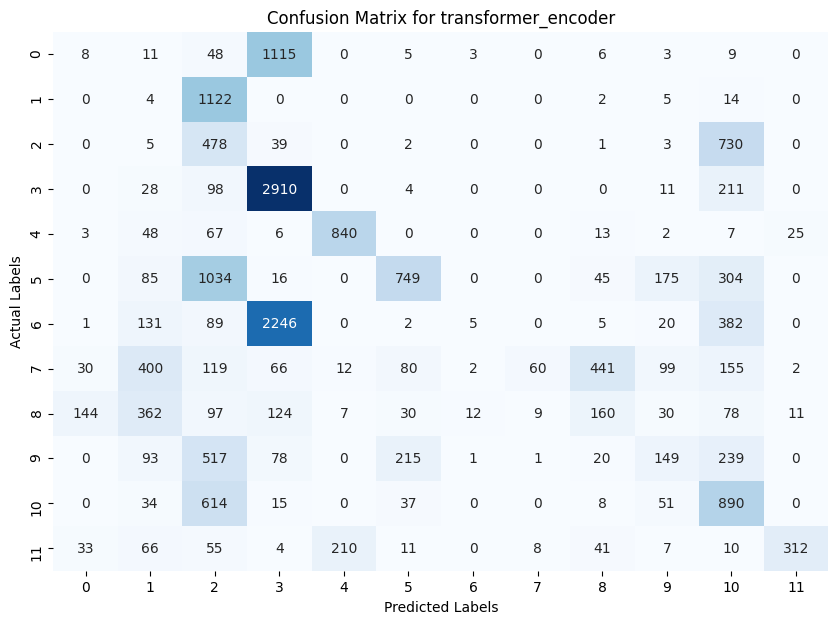

In [36]:
# draw confusion matrix, print the report

from sklearn.metrics import classification_report, confusion_matrix

def plot_classification_report_confusion_matrix(models, X_test, y_test):
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        print(f"Classification Report for {model_name}:\n")
        print(classification_report(y_test, y_pred_classes))

        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred_classes)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f'Confusion Matrix for {model_name}')
        plt.ylabel('Actual Labels')
        plt.xlabel('Predicted Labels')
        plt.show()


            
plot_classification_report_confusion_matrix(trained_models, X_test_seq, y_test_seq)

----

### TimeGAN

- **Reference**
    - https://github.com/flaviagiammarino/time-gan-tensorflow/blob/main/example/example.py
    - https://proceedings.neurips.cc/paper_files/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf
    - https://minsoo9506.github.io/05-timegan/
    - https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/21_gans_for_synthetic_time_series/README.md

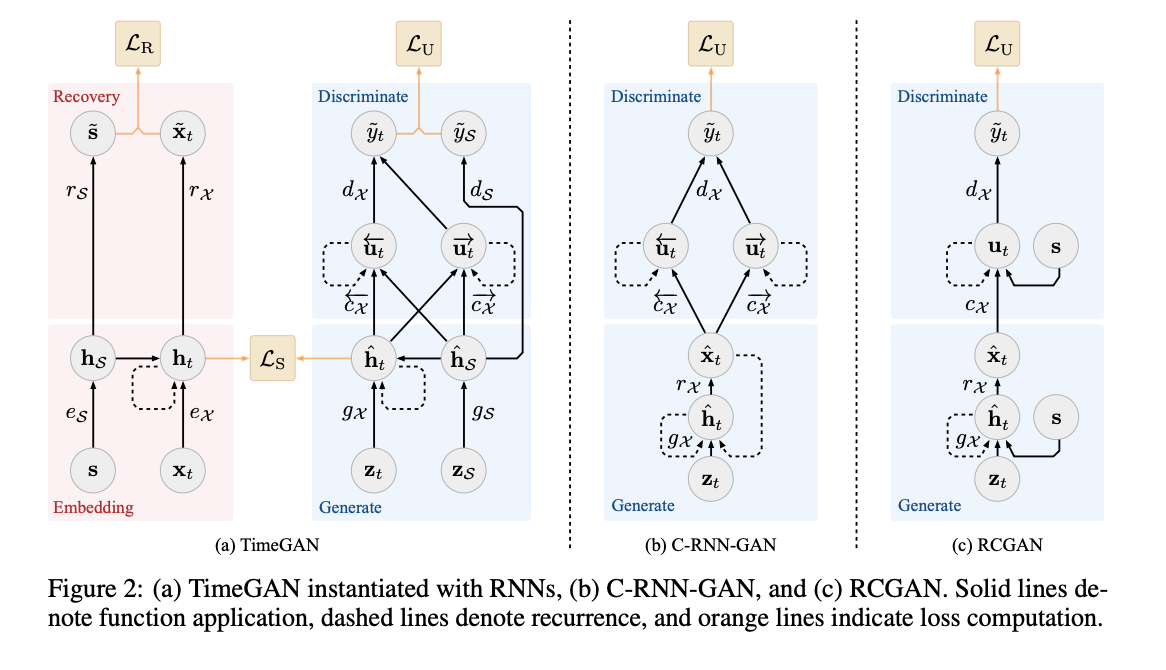

**TimeGAN (Time-series Generative Adversarial Network) is a specialized model designed to generate synthetic time-series data that captures real-world patterns and behaviors.** Unlike traditional GANs that focus on static data like images, TimeGAN excels at handling data with **temporal dependencies and sequential patterns**.
What sets TimeGAN apart is its innovative hybrid learning approach. While traditional GANs rely purely on unsupervised learning to distinguish between real and generated data, TimeGAN combines both supervised and unsupervised techniques. This dual approach helps the model better understand and preserve the complex temporal relationships found in time-series data, resulting in more authentic and meaningful synthetic sequences rather than just random variations. By maintaining these temporal dependencies, TimeGAN can generate highly realistic time-series data that closely mirrors the patterns and behaviors found in real-world sequences.

Thus, I read and implemented the TimeGAN paper. I referred to the code on GitHub at https://github.com/flaviagiammarino/time-gan-tensorflow/blob/main/example/example.py. Ultimately, to accurately capture the temporal dynamics discussed in the paper, I used an LSTM. One key difference between TimeGAN and a traditional GAN is that, instead of generating data directly in the feature space, the generator first creates an embedding space. This embedding space is then used to generate the data, which is the primary distinction.

In [87]:
class TimeGAN:
    def __init__(self, seq_length=100, num_features=35, hidden_dim=64):
        self.seq_length = seq_length
        self.num_features = num_features
        self.hidden_dim = hidden_dim

        # Define the models
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.encoder = self.build_encoder()

    def build_generator(self):
        model = tf.keras.Sequential()
        model.add(layers.LSTM(self.hidden_dim, return_sequences=True, input_shape=(self.seq_length, self.num_features)))
        model.add(layers.LSTM(self.num_features, return_sequences=True))
        return model

    def build_discriminator(self):
        model = tf.keras.Sequential()
        model.add(layers.LSTM(self.hidden_dim, return_sequences=True, input_shape=(self.seq_length, self.num_features)))
        model.add(layers.LSTM(1, return_sequences=False))
        return model

    def build_encoder(self):
        model = tf.keras.Sequential()
        model.add(layers.LSTM(self.hidden_dim, return_sequences=True, input_shape=(self.seq_length, self.num_features)))
        return model

    def compile_models(self):
        # Compile the models with optimizers and loss functions
        self.generator.compile(loss='mse', optimizer='adam')
        self.discriminator.compile(loss=self.wasserstein_loss, optimizer='adam')
        self.encoder.compile(loss='mse', optimizer='adam')

    def wasserstein_loss(self, y_true, y_pred):
        # Convert y_true to float32 to perform multiplication
        return tf.reduce_mean(tf.cast(y_true, tf.float32) * y_pred)

    def gradient_penalty(self, real_samples, fake_samples):
        # Calculate gradient penalty
        alpha = tf.random.uniform(shape=[real_samples.shape[0], 1, 1], minval=0., maxval=1.)
        interpolated = alpha * real_samples + (1 - alpha) * fake_samples
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            interpolated_logits = self.discriminator(interpolated)
        gradients = tape.gradient(interpolated_logits, interpolated)
        gradient_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2]))
        return tf.reduce_mean(tf.maximum(0., gradient_norm - 1.))  # L2 normalization


In [75]:
def gradient_penalty(self, real_samples, fake_samples):
    alpha = tf.random.uniform(shape=[real_samples.shape[0], 1, 1], minval=0., maxval=1.)
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        interpolated_logits = self.discriminator(interpolated)
    gradients = tape.gradient(interpolated_logits, interpolated)
    gradient_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2]))
    return tf.reduce_mean(tf.maximum(0., gradient_norm - 1.))  # L2 정규화

In [88]:
def train_time_gan(time_gan, data, epochs=1000, batch_size=32):
    for epoch in range(epochs):
        idx = np.random.randint(0, data.shape[0] - time_gan.seq_length - 1, size=batch_size)
        real_samples = data[idx]  # Select real samples

        noise = np.random.normal(0, 1, (batch_size, time_gan.seq_length, time_gan.num_features))
        fake_samples = time_gan.generator.predict(noise)

        combined_samples = np.concatenate([real_samples, fake_samples])
        labels = np.array([1] * batch_size + [0] * batch_size)  # Real: 1, Fake: 0

        # Calculate gradient penalty
        gp = time_gan.gradient_penalty(real_samples, fake_samples)
        d_loss = time_gan.discriminator.train_on_batch(combined_samples, labels) + gp

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, time_gan.seq_length, time_gan.num_features))
        dummy_labels = np.zeros((batch_size, time_gan.seq_length, time_gan.num_features))  # Dummy labels
        g_loss = time_gan.generator.train_on_batch(noise, dummy_labels)

        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}')

In [89]:
time_gan = TimeGAN(seq_length=100, num_features=35)
time_gan.compile_models()

In [90]:
train_time_gan(time_gan, X_train_seq, epochs=5000, batch_size=32)


1/1 [==============================] - 1s 500ms/step
Epoch: 0, Discriminator Loss: 0.01877514086663723, Generator Loss: 0.006023085676133633
1/1 [==============================] - 0s 31ms/step
Epoch: 1000, Discriminator Loss: -0.4999750852584839, Generator Loss: 7.494898000004468e-07
1/1 [==============================] - 0s 33ms/step
Epoch: 2000, Discriminator Loss: -0.49998998641967773, Generator Loss: 3.1965868174665957e-07
1/1 [==============================] - 0s 31ms/step
Epoch: 3000, Discriminator Loss: -0.49999600648880005, Generator Loss: 1.7161958965061785e-07
1/1 [==============================] - 0s 31ms/step
Epoch: 4000, Discriminator Loss: -0.4999977946281433, Generator Loss: 1.3083972305594216e-07
1/1 [==============================] - 0s 32ms/step


In [91]:
def generate_synthetic_data(time_gan, num_samples=100000):
    noise = np.random.normal(0, 1, (num_samples, time_gan.seq_length, time_gan.num_features))
    synthetic_data = time_gan.generator.predict(noise)
    
    return synthetic_data

num_synthetic_samples = len(y_train_seq)
synthetic_data = generate_synthetic_data(time_gan, num_samples=num_synthetic_samples)

print("Synthetic Data Shape:", synthetic_data.shape)

2429/2429 [==============================] - 9s 3ms/step
Synthetic Data Shape: (77710, 100, 35)


In [92]:
X = np.vstack((X_train_seq, synthetic_data))
y = np.concatenate((y_train_seq, y_train_seq))

print (X.shape, y.shape)

(155420, 100, 35) (155420,)


In [93]:
# fit

histories_TimeGAN, trained_models = activate_all_model(X, y, input_shape, n_classes)

CNN_LSTM model parameters: 107228
UNet model parameters: 164572
Transformer Encoder model parameters: 114934
ERROR: Could not find file /tmp/ipykernel_409/2458058224.py
model 0 running
epoch 1 completed : 24.43 seconds
epoch 2 completed : 4.18 seconds
epoch 3 completed : 4.18 seconds
epoch 4 completed : 4.15 seconds
epoch 5 completed : 4.13 seconds
epoch 6 completed : 4.06 seconds
epoch 7 completed : 4.07 seconds
epoch 8 completed : 4.19 seconds
epoch 9 completed : 4.15 seconds
epoch 10 completed : 4.11 seconds
epoch 11 completed : 4.09 seconds
epoch 12 completed : 4.05 seconds
epoch 13 completed : 4.22 seconds
epoch 14 completed : 4.19 seconds
epoch 15 completed : 4.17 seconds
epoch 16 completed : 4.22 seconds
epoch 17 completed : 4.15 seconds
epoch 18 completed : 4.22 seconds
epoch 19 completed : 4.17 seconds
epoch 20 completed : 4.10 seconds
epoch 21 completed : 4.23 seconds
epoch 22 completed : 4.10 seconds
epoch 23 completed : 4.14 seconds
epoch 24 completed : 4.10 seconds
epoch 2

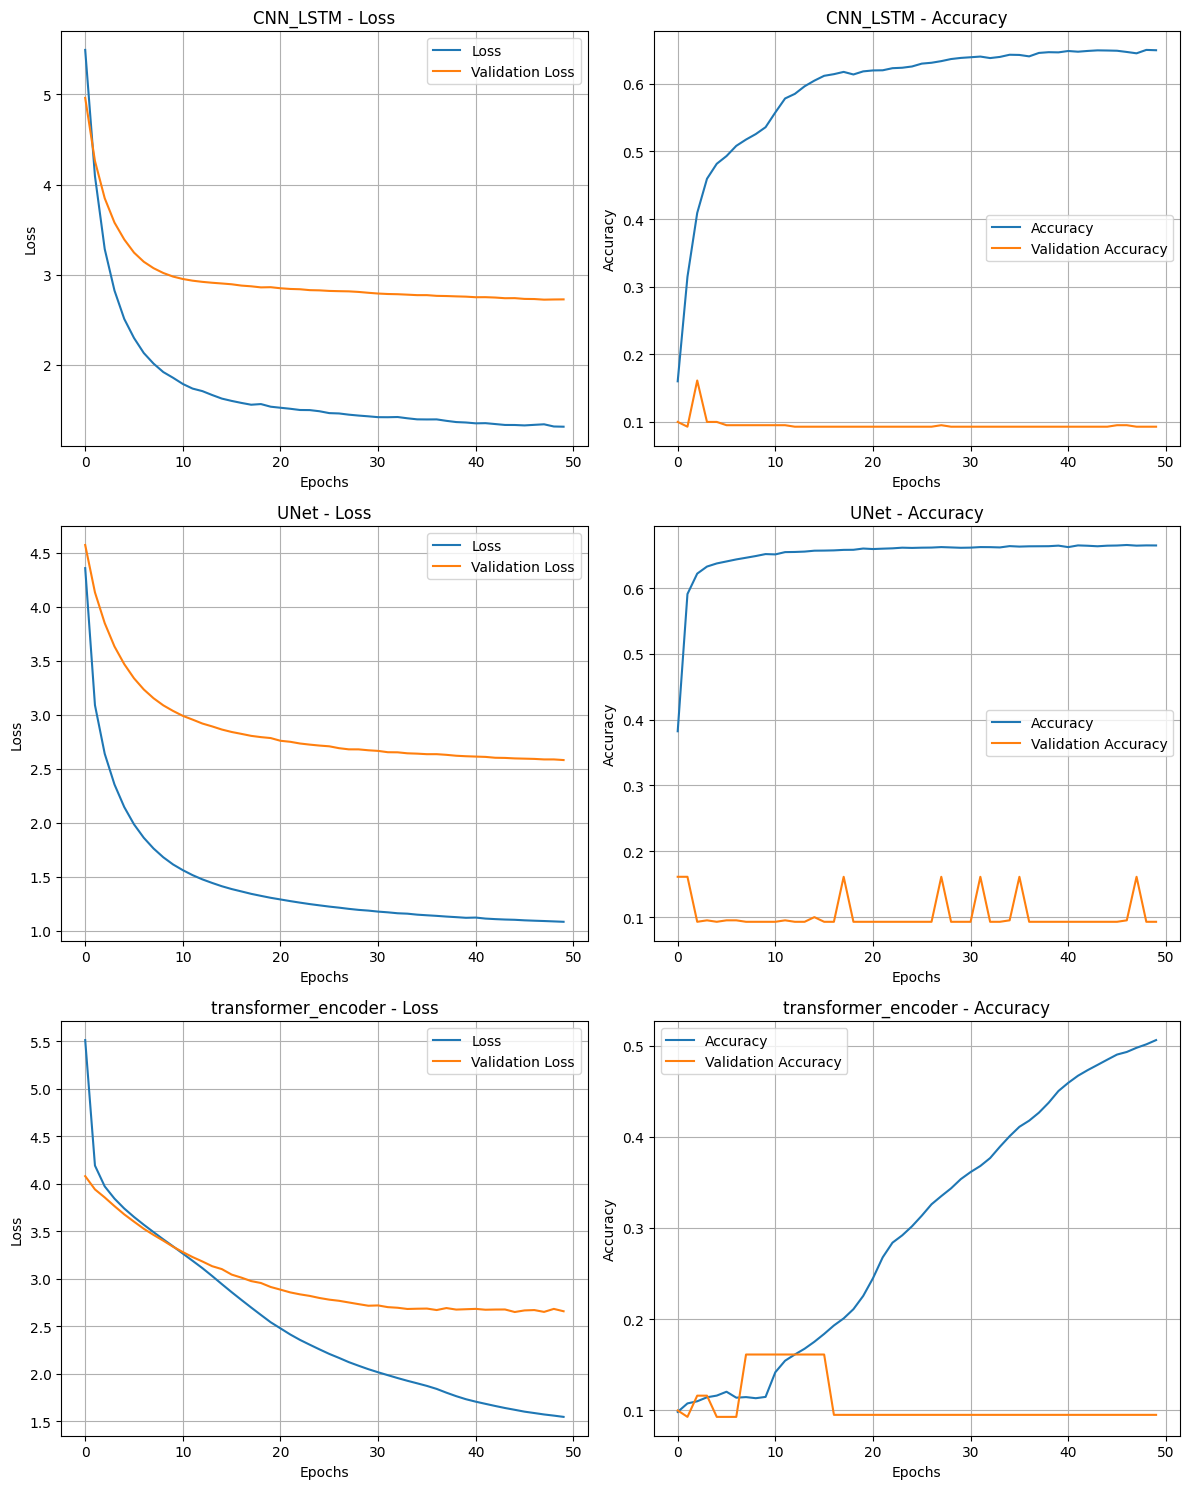

In [94]:
# draw loss, val_loss, acc, val_acc

draw_history(histories_TimeGAN)

In [95]:
# evaluate

evaluation_TimeGAN = extract_train_test_scores(trained_models, X, y,
                                                 X_test_seq, y_test_seq)
print (evaluation_TimeGAN)

{'CNN_LSTM': {'train_score': [1.5373878479003906, 0.5506691336631775], 'test_score': [3.3836796283721924, 0.4041392207145691]}, 'UNet': {'train_score': [1.379895567893982, 0.5521296858787537], 'test_score': [3.17425799369812, 0.4644254446029663]}, 'transformer_encoder': {'train_score': [1.8456261157989502, 0.39783811569213867], 'test_score': [3.2447967529296875, 0.32145798206329346]}}


In [96]:
# get accuracy, precision, recall, F1 score

performances_TimeGAN = extract_performance_metrics(trained_models, X_test_seq, y_test_seq)
print (performances_TimeGAN)

607/607 [==============================] - 2s 2ms/step
{'CNN_LSTM': {'accuracy': 0.4041392092257002, 'precision': 0.4051819535216352, 'recall': 0.4041392092257002, 'f1_score': 0.3562731034456238}, 'UNet': {'accuracy': 0.46442545304777594, 'precision': 0.41984810966840574, 'recall': 0.46442545304777594, 'f1_score': 0.4201220532161189}, 'transformer_encoder': {'accuracy': 0.3214579901153213, 'precision': 0.3757931705363445, 'recall': 0.3214579901153213, 'f1_score': 0.29890246556750244}}


607/607 [==============================] - 2s 4ms/step
Classification Report for CNN_LSTM:

              precision    recall  f1-score   support

           0       0.60      0.13      0.22      1208
           1       0.48      0.97      0.64      1147
           2       0.87      0.81      0.84      1258
           3       0.50      0.58      0.53      3262
           4       0.31      0.47      0.38      1011
           5       0.43      0.16      0.23      2408
           6       0.28      0.04      0.07      2881
           7       0.49      0.56      0.52      1466
           8       0.22      0.57      0.31      1064
           9       0.21      0.61      0.31      1313
          10       0.00      0.00      0.00      1649
          11       0.64      0.66      0.65       757

    accuracy                           0.40     19424
   macro avg       0.42      0.46      0.39     19424
weighted avg       0.41      0.40      0.36     19424



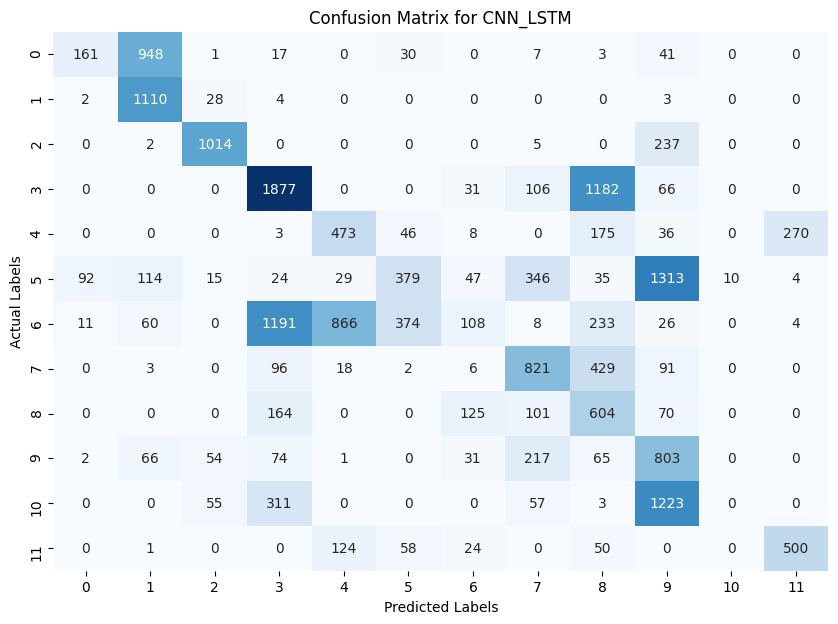

607/607 [==============================] - 1s 2ms/step
Classification Report for UNet:

              precision    recall  f1-score   support

           0       0.02      0.00      0.00      1208
           1       0.01      0.00      0.00      1147
           2       0.31      0.89      0.46      1258
           3       0.55      0.53      0.54      3262
           4       0.53      0.50      0.52      1011
           5       0.77      0.81      0.79      2408
           6       0.55      0.35      0.43      2881
           7       0.51      0.56      0.53      1466
           8       0.28      0.48      0.35      1064
           9       0.34      0.81      0.48      1313
          10       0.00      0.00      0.00      1649
          11       0.65      0.39      0.49       757

    accuracy                           0.46     19424
   macro avg       0.38      0.44      0.38     19424
weighted avg       0.42      0.46      0.42     19424



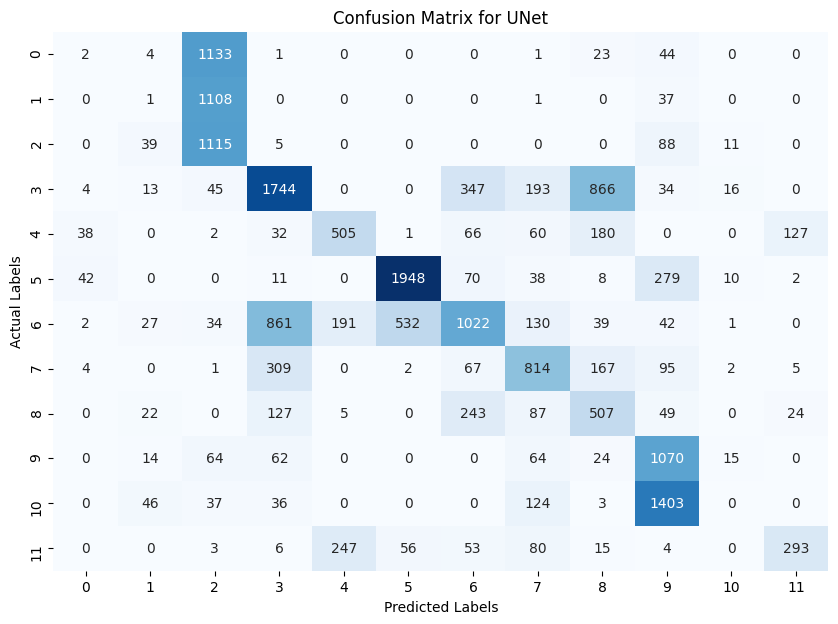

607/607 [==============================] - 1s 2ms/step
Classification Report for transformer_encoder:

              precision    recall  f1-score   support

           0       0.53      0.98      0.69      1208
           1       0.00      0.00      0.00      1147
           2       0.09      0.05      0.07      1258
           3       0.47      0.57      0.52      3262
           4       0.32      0.14      0.19      1011
           5       0.74      0.32      0.45      2408
           6       0.48      0.05      0.09      2881
           7       0.20      0.42      0.28      1466
           8       0.20      0.09      0.13      1064
           9       0.18      0.17      0.18      1313
          10       0.29      0.49      0.36      1649
          11       0.35      0.44      0.39       757

    accuracy                           0.32     19424
   macro avg       0.32      0.31      0.28     19424
weighted avg       0.38      0.32      0.30     19424



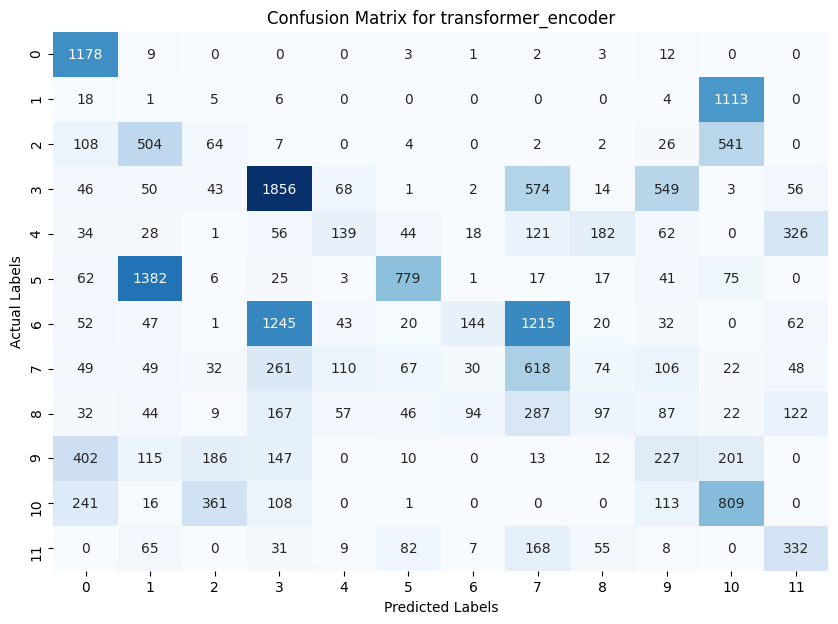

In [97]:
# draw confusion matrix, print the report

plot_classification_report_confusion_matrix(trained_models, X_test_seq, y_test_seq)

------

### SMOTified-GAN

- **Reference**
    - https://kiss.kstudy.com/Detail/Ar?key=4059334
    - https://github.com/anuraganands/SMOTified-GAN_release_version

Using SMOTified-GAN, I address the imbalance problem in the PAMAP2 dataset and subsequently perform augmentation through GAN. This approach is particularly applicable when there is insufficient source class data for GAN to process effectively on its own. Instead of generating samples randomly, GAN will operate on the pre-sampled minority data produced by SMOTE.

In [111]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

class GAN:
    def __init__(self, input_dim):
        self.input_dim = input_dim
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.compile_models()

    def build_generator(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(64, activation='relu', input_dim=self.input_dim))  # Reduced units
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(self.input_dim, activation='sigmoid'))  # Match output dimensions
        return model

    def build_discriminator(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(128, activation='relu', input_dim=self.input_dim))  # Reduced units
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        return model

    def compile_models(self):
        self.discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        self.discriminator.trainable = False
        
        gan_input = layers.Input(shape=(self.input_dim,))
        generated = self.generator(gan_input)
        gan_output = self.discriminator(generated)
        self.gan = tf.keras.Model(gan_input, gan_output)
        self.gan.compile(optimizer='adam', loss='binary_crossentropy')

    def train(self, x_train, epochs=5000, batch_size=128):
        for epoch in range(epochs):
            # Generate random noise
            noise = np.random.normal(0, 1, size=[batch_size, self.input_dim])
            generated_samples = self.generator.predict(noise)

            # Sample from the real dataset
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            real_samples = x_train[idx]

            # Concatenate real and fake samples
            combined_samples = np.concatenate([real_samples, generated_samples])
            labels = np.array([1] * batch_size + [0] * batch_size)

            # Train the discriminator
            d_loss = self.discriminator.train_on_batch(combined_samples, labels)

            # Train the generator
            noise = np.random.normal(0, 1, size=[batch_size, self.input_dim])
            g_loss = self.gan.train_on_batch(noise, np.array([1] * batch_size))  # Fake labels for generator

            if epoch % 2 == 0:
                print(f'Epoch {epoch}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}')


In [112]:
def smotified_gan(X, y):
    smote = SMOTE(sampling_strategy='auto')
    X_resampled, y_resampled = smote.fit_resample(X, y)

    input_dim = X_resampled.shape[1]
    gan = GAN(input_dim)
    
    gan.train(X_resampled)

    noise = np.random.normal(0, 1, size=(100000, input_dim)) 
    augmented_data = gan.generator.predict(noise)
    
    return augmented_data, y_resampled

In [109]:
augmented_data, augmented_labels = smotified_gan(X_train, y_train)

print ("augmented data shape :", augmented_data.shape)
print ("augmented labels shape :", augmented_labels.shape)

KeyboardInterrupt: 

In [ ]:
train_set = np.c_[augmented_data, augmented_labels]

X_seq, y_seq = split_sequences_freq(train_set, 100, 20) # tie 100 records, hop 20

X = np.vstack((X_train_seq, X_seq))
y = np.concatenate((y_train_seq, y_seq))

print (X.shape, y.shape)

In [ ]:
# fit

histories_SMOTified_GAN, trained_models = activate_all_model(X, y, input_shape, n_classes)

In [ ]:
# draw loss, val_loss, acc, val_acc

draw_history(histories_SMOTified_GAN)

In [ ]:
# evaluate

evaluation_SMOTified_GAN = extract_train_test_scores(trained_models, X, y,
                                                 X_test_seq, y_test_seq)
print (evaluation_SMOTified_GAN)

In [ ]:
# get accuracy, precision, recall, F1 score

performances_SMOTified_GAN = extract_performance_metrics(trained_models, X_test_seq, y_test_seq)
print (performances_SMOTified_GAN)

In [ ]:
# draw confusion matrix, print the report

plot_classification_report_confusion_matrix(trained_models, X_test_seq, y_test_seq)

In [ ]:
print (10)

---

### comparison each augmentation result

In [ ]:
evaluation_data = {
    "original": evaluation_original,
    "TimeGAN" : evaluation_TimeGAN,
    "SMOTified_GAN" : evaluation_SMOTified_GAN
}

performance_data = {
    "original": performances_original,
    "TimeGAN" : performances_TimeGAN,
    "SMOTified_GAN" : performances_SMOTified_GAN
}

aug_list = ['original', 'TimeGAN', 'SMOTified_GAN']
histories_dict = {
    "original": histories_original,
    "TimeGAN" : histories_TimeGAN,
    "SMOTified_GAN" : histories_SMOTified_GAN
}


In [ ]:
import matplotlib.pyplot as plt

def plot_augmented_losses(histories_dict, aug_list):
    fig, axes = plt.subplots(len(aug_list), 3, figsize=(18, len(aug_list) * 4))
    
    for i, aug in enumerate(aug_list):
        history = histories_dict[aug]
        
        for j, model_name in enumerate(['CNN_LSTM', 'UNet', 'transformer_encoder']):
            ax = axes[i, j] if len(aug_list) > 1 else axes[j]
            
            if history[model_name] is not None:
                ax.plot(history[model_name].history['loss'], label='Train Loss', color='b')
                ax.plot(history[model_name].history['val_loss'], label='Validation Loss', color='orange')
                
                ax.set_title(f"{model_name} - {aug}")
                ax.set_xlabel("Epoch")
                ax.set_ylabel("Loss")
                ax.legend()
            else:
                ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_augmented_losses(histories_dict, aug_list)


In [ ]:
def plot_loss_comparison(evaluation_data):
    plt.figure(figsize=(16, 10))
    
    for model in ['CNN_LSTM', 'UNet', 'transformer_encoder']:
        train_losses = []
        test_losses = []
        aug_labels = []
        
        for aug, data in evaluation_data.items():
            train_loss = data[model]['train_score'][0]
            test_loss = data[model]['test_score'][0]
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            aug_labels.append(aug)
        
        plt.plot(aug_labels, train_losses, marker='o', label=f"{model} - Train Loss")
        plt.plot(aug_labels, test_losses, marker='x', label=f"{model} - Test Loss")

    plt.ylabel("Loss")
    plt.xlabel("Augmentation Method")
    plt.title("Train and Test Loss Comparison by Model and Augmentation Method")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_loss_comparison(evaluation_data)


In [ ]:
def plot_performance_comparison(performance_data, metric="accuracy"):
    plt.figure(figsize=(16, 10))
    
    for model in ['CNN_LSTM', 'UNet', 'transformer_encoder']:
        performance_scores = []
        aug_labels = []
        
        for aug, data in performance_data.items():
            performance = data[model][metric]
            performance_scores.append(performance)
            aug_labels.append(aug)
        
        plt.plot(aug_labels, performance_scores, marker='o', label=f"{model} - {metric.capitalize()}")

    plt.ylabel(metric.capitalize())
    plt.xlabel("Augmentation Method")
    plt.title(f"{metric.capitalize()} Comparison by Model and Augmentation Method")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_performance_comparison(performance_data, metric="accuracy")
plot_performance_comparison(performance_data, metric="precision")
plot_performance_comparison(performance_data, metric="recall")
plot_performance_comparison(performance_data, metric="f1_score")
